In [1]:
# default_exp nsfg

In [2]:
%matplotlib inline

# NSFG

> Reading of NSFG [1] .dat and .dct files.

[[1]](https://www.cdc.gov/nchs/nsfg/nsfg_2015_2017_puf.htm#downloadable) NSFG survey

In [27]:
#export
from pathlib import Path
import pandas as pd
import os, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [28]:
#hide
mpl.style.use("bmh")

In [29]:
#export
data_dir = Path("../data/nsfg")

In [30]:
data_dir

WindowsPath('../data/nsfg')

In [31]:
#export
dat_file = "2002FemPreg.dat"
dct_file = "2002FemPreg.dct"

In [32]:
data_dir/dat_file, data_dir/dct_file

(WindowsPath('../data/nsfg/2002FemPreg.dat'),
 WindowsPath('../data/nsfg/2002FemPreg.dct'))

## Parsing DCT files

In [33]:
#export
def type_sub(x, type_map:dict):
    "Substitutes types as found in dct files"
    if x in type_map:
        return type_map[x]
    elif x.startswith("str"):
        return "str"
    else:
        raise ValueError(f"Received an unexpected value for `x` = '{x}'")

def get_dct_dataframe(path:Path):
    "Parses survey description information contained ina *.dct file"
    type_map = {"byte":"int", "int":"int", "long":"int", "float":"float", "double":"float", "numeric":"float"}
    var_info = []
    assert path.name.endswith("dct")
    with open(path, "r") as f:
        for line in f:
            match = re.search(r"_column\((\d*)\)", line)
            if match is None: continue
            start = match.group(1)
            _, vtype, name, fstring, desc = line.split(maxsplit=4)
            desc = desc.strip()[1:-1]
            var_info.append([start, vtype, name, fstring, desc])

    dct = pd.DataFrame(var_info, columns=["start", "vtype", "name", "fstring", "desc"])
    dct["vtype"] = dct["vtype"].apply(type_sub, type_map=type_map)
    dct["start"] = dct["start"].astype(int)
    dct["end"] = np.concatenate((dct.start[1:].values,[0]))
    
    return dct.infer_objects()

In [34]:
dct = get_dct_dataframe(data_dir/dct_file)
dct.head()

,start,vtype,name,fstring,desc,end
0,1,str,caseid,%12s,RESPONDENT ID NUMBER,13
1,13,int,pregordr,%2f,PREGNANCY ORDER (NUMBER),15
2,15,int,howpreg_n,%2f,BB-2 # OF WEEKS OR MONTHS CURRENTLY PREGNANT,17
3,17,int,howpreg_p,%1f,BB-2 CURRENT PREGNANCY LENGTH REPORTED IN MONT...,18
4,18,int,moscurrp,%1f,NUMBER OF MONTHS CURRENTLY PREGNANT,19


In [35]:
len(dct), len(dct.columns)

(243, 6)

In [36]:
#hide
assert len(dct) == 243 and len(dct.columns) == 6

## Parsing DAT files

In [37]:
# export
def get_dat_dataframe(path:Path, dct:pd.DataFrame, index_base:int=1):
    "Parses survey data in a *.dat file using the previously parsed description information contained in a *.dct file"
    colspecs = (dct[["start", "end"]].values-index_base).tolist()  # defines the extend of each column
    dat = pd.read_fwf(path, names=dct.name, colspecs=colspecs)
    return dat

In [38]:
%%time
dat = get_dat_dataframe(data_dir/dat_file, dct)

Wall time: 1.76 s


In [39]:
dat.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,poverty_i,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231


In [40]:
len(dat), len(dat.columns)

(13593, 243)

In [41]:
#hide
assert len(dat) == 13593 and len(dat.columns) == 243

## Basic EDA

In [42]:
#export
def display_all(df:pd.DataFrame, nrows:int=1000, ncols:int=1000, sort_values:bool=False, ascending:bool=False):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df.sort_values(ascending=ascending) if sort_values else df)

In [43]:
#hide
display_all(dat.isnull().sum()/len(dat), sort_values=True)

fedsolid3          1.000000
quitnurs3          1.000000
ageqtnur3          0.999926
ageqtnur_p3        0.999926
frsteatd_p3        0.999926
frsteatd_n3        0.999926
dk1gest            0.999926
frsteatd3          0.999926
ageqtnur_n3        0.999926
legagree3          0.999926
wantbld2           0.999853
lobthwgt3          0.999853
ltrimest           0.999853
cmkidlft3          0.999779
wherenow3          0.999779
nowprgdk           0.999779
parenend3          0.999779
cmkidied3          0.999706
lobthwgt2          0.999632
lastage3           0.999632
alivenow3          0.999485
bpa_bdscheck3      0.999485
legagree2          0.999485
weeksdk            0.999411
lpnctri            0.999338
paybirth3          0.999338
whynouse3          0.999338
cmkidied2          0.999191
pnctrim            0.999191
livehere3          0.999191
trimestr           0.999044
anynurse3          0.998970
fedsolid2          0.998970
whatmeth04         0.998896
whyprg2            0.998896
parenend2          0

In [44]:
#export
columns_of_interest = ["caseid", "prglngth", "outcome", "pregordr", "birthord", "birthwgt_lb", 
                       "birthwgt_oz", "agepreg", "finalwgt"]

In [45]:
df = dat[columns_of_interest].copy()

In [46]:
#hide
df.head()

,caseid,prglngth,outcome,pregordr,birthord,birthwgt_lb,birthwgt_oz,agepreg,finalwgt
0,1,39,1,1,1.0,8.0,13.0,3316.0,6448.271112
1,1,39,1,2,2.0,7.0,14.0,3925.0,6448.271112
2,2,39,1,1,1.0,9.0,2.0,1433.0,12999.542264
3,2,39,1,2,2.0,7.0,0.0,1783.0,12999.542264
4,2,39,1,3,3.0,6.0,3.0,1833.0,12999.542264


In [47]:
display_all(df.isnull().sum()/len(df), sort_values=True)

birthwgt_oz    0.331494
birthwgt_lb    0.327301
birthord       0.327007
agepreg        0.025896
finalwgt       0.000000
pregordr       0.000000
outcome        0.000000
prglngth       0.000000
caseid         0.000000
dtype: float64

In [48]:
#export
def cleanup(df:pd.DataFrame):
    "Doing some cleanup as specified in chapter 1"
    df.agepreg /= 100.
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)

    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0
    df['totalwgt_kg'] = df['totalwgt_lb'] * .453592
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    return df

In [49]:
df = cleanup(df)

Wall time: 2.56 s


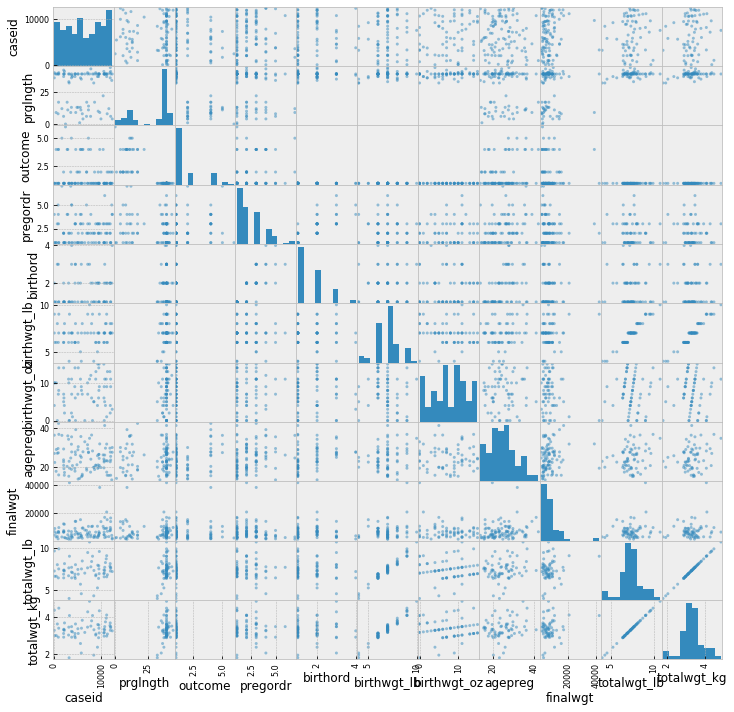

In [50]:
%%time
ax = pd.plotting.scatter_matrix(df.sample(n=100), figsize=(12,12))

In [51]:
#hide
df.outcome.value_counts()

1    9148
4    1921
2    1862
6     352
5     190
3     120
Name: outcome, dtype: int64

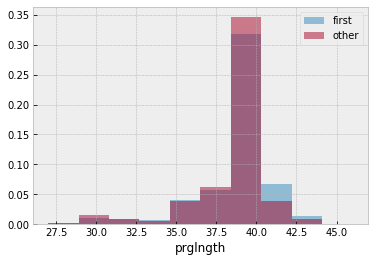

In [52]:
col = "prglngth"
col1 = "birthord"

xlim = [27,46]
ax = df.loc[df[col1]==1, col].hist(alpha=.5, label="first", range=xlim, density=True)
ax = df.loc[df[col1]!=1, col].hist(ax=ax, alpha=.5, label="other", range=xlim, density=True)
ax.legend()
ax.set_xlabel(col)
plt.show()

## Export cleaned NSFG data

In [56]:
# export
clean_file_path = data_dir.parent/"2002FemPreg.csv"

In [57]:
clean_file_path

WindowsPath('../data/2002FemPreg.csv')

In [55]:
df.to_csv(clean_file_path, index=False, encoding="utf8")